In [34]:
import numpy as np
import matplotlib.pyplot as plt

## Load LLM

In [5]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    device_map="auto",   
    torch_dtype=torch.float16,
)
print(f"finish loading model")
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


finish loading tokenizer


Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]

finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

## Define Trainer

In [26]:
import gymnasium as gym
from llmicl.interfaces import trainers  # import RLICLTrainer

import importlib
importlib.reload(trainers)

<module 'llmicl.interfaces.trainers' from '/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py'>

In [27]:
env = gym.make("HalfCheetah")
trainer = trainers.RLICLTrainer(
    env=env,
    model=model,
    tokenizer=tokenizer,
    rescale_factor=7.0,
    up_shift=1.5,
)

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(


## Generate time series

In [28]:
from llmicl.rl_helpers.rl_utils import load_offline_dataset

In [40]:
context_length = 200
init_index = 1506

data_path = "/home/abenechehab/d4rl_halfcheetah/d4rl_expert_80k_20k/X_test.csv"
X, _, n_observations, n_actions = load_offline_dataset(path=data_path)

time_series = X[init_index:init_index+context_length, :n_observations]

## show time

In [41]:
trainer.update_context(time_series=time_series, context_length=context_length)
trainer.icl(verbose=1)
icl_object = trainer.compute_statistics()

icl / state dim: 100%|███████████████████████████████████████████████████████████████████████████████████| 17/17 [00:04<00:00,  3.98it/s]


## Visualize

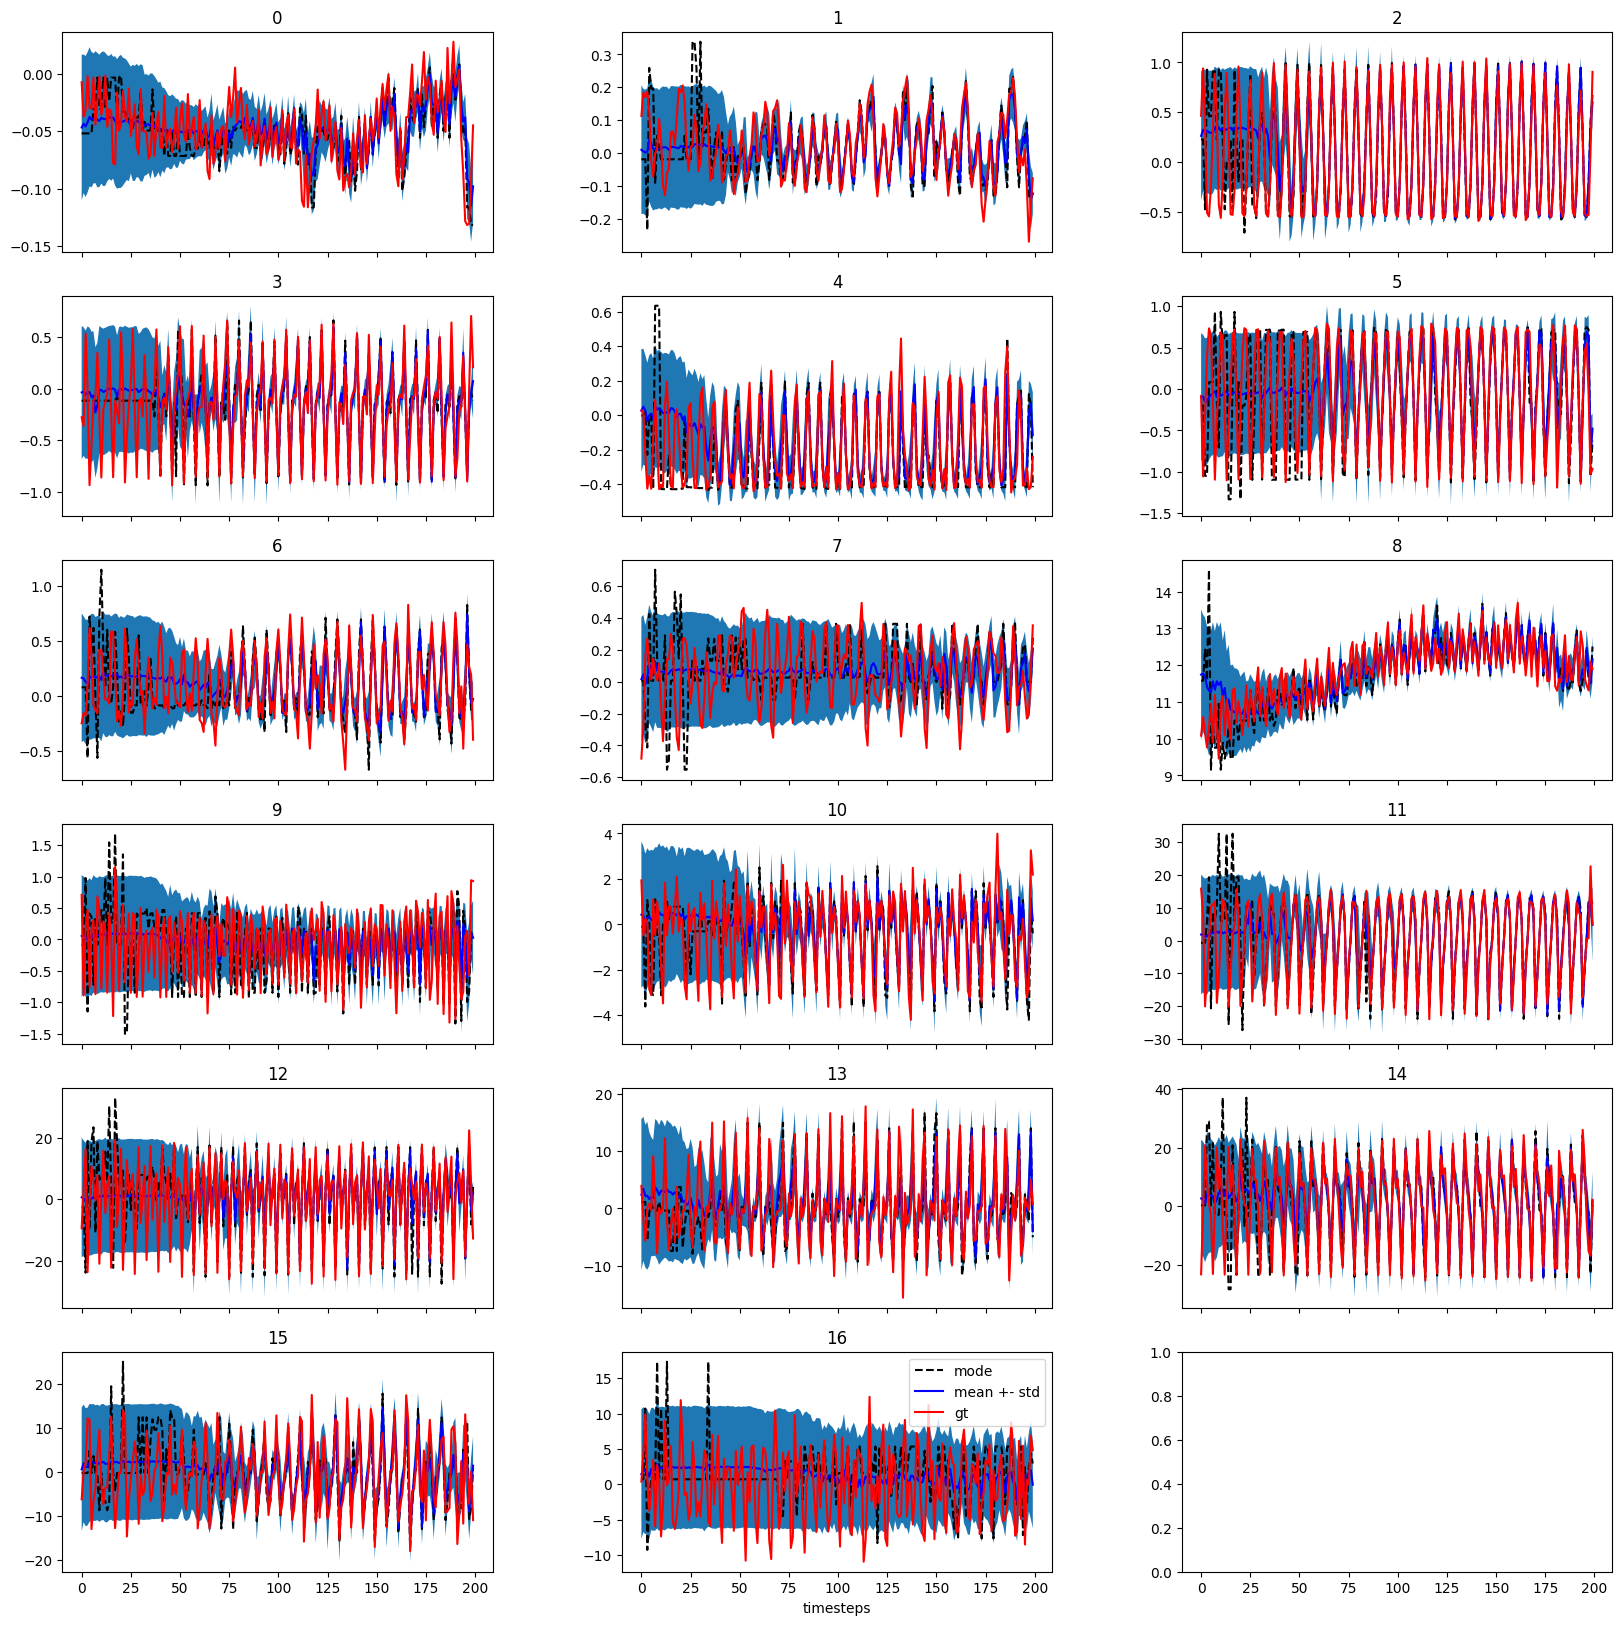

In [44]:
rescale_factor=7.0
up_shift=1.5
f, axes = plt.subplots(6, 3, figsize=(20, 20), gridspec_kw={'wspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for dim in range(n_observations):
    groundtruth = X[init_index+1:init_index+context_length+1, dim].flatten()
    
    ts_max = icl_object[dim].rescaling_max
    ts_min = icl_object[dim].rescaling_min
    # -------------------- Useful for Plots --------------------
    mode_arr = ((icl_object[dim].mode_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min 
    mean_arr = ((icl_object[dim].mean_arr.flatten() - up_shift) / rescale_factor) * (ts_max - ts_min) + ts_min
    sigma_arr = (icl_object[dim].sigma_arr.flatten() / rescale_factor) * (ts_max - ts_min)

    # -------------------- Trajectory visualization --------------------
    x = np.arange(mean_arr.shape[0])

    axes[dim].plot(x, mode_arr, 'k--',label='mode')
    axes[dim].plot(x, mean_arr, label='mean +- std', color='blue')
    axes[dim].fill_between(x=x, y1=mean_arr-sigma_arr, y2=mean_arr+sigma_arr)
    axes[dim].plot(x, groundtruth, label='gt', color='red')
    axes[dim].set_title(f"{dim}")
    if dim > 15:
        axes[dim].set_xlabel("timesteps")
axes[dim].legend()
# plt.savefig(f"RL_figures/traj_{columns[feature] if all_dim else columns[dim]}_{policy}.png")
plt.show()